## Estimación de pobreza de vivienda de acuerdo con Evalúa CDMX

El siguiente script descarga los microdatos de la ENIGH, procesa la información y estima la pobreza de vivienda en la Ciudad de México para los años 2018, 2020 y 2022. La estimación se realiza de acuerdo con la metodología de Evalúa CDMX. https://www.evalua.cdmx.gob.mx/medicion-de-la-pobreza-desigualdad-e-indice-de-desarrollo-social/medicion-de-la-pobreza-2018-2022

In [12]:
##Estimación de pobreza de vivienda de acuerdo con Evalúa CDMX
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

Using GitHub PAT from the git credential store.




rlang (1.1.4 -> 1.1.6) [CRAN]
glue  (1.7.0 -> 1.8.0) [CRAN]
cli   (3.6.3 -> 3.6.5) [CRAN]


Installing 3 packages: rlang, glue, cli

Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

Warning message in download.file(url, destfile, method, mode = "wb", ...):
"downloaded length 31930 != reported length 184237"
Warning message in download.file(url, destfile, method, mode = "wb", ...):
"URL 'https://cran.r-project.org/bin/windows/contrib/4.4/glue_1.8.0.zip': Timeout of 60 seconds was reached"


Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.r-project.org/bin/windows/contrib/4.4/glue_1.8.0.zip' failed


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
"download of package 'glue' failed"


package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\Rtmpqgkr6O\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\Rtmpqgkr6O\remotes2204ba91245\cpyp-ipdp-funcionespgd-d9421b2/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Warning message:
"package 'funcionespgd' is in use and will not be installed"


### Descarga de microdatos de ENIGH

In [13]:
# Definir URL base y parte intermedia
url_basica <- "https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte <- "microdatos/enigh"

# Definir los años y los tipos de archivos a descargar
years <- c("2018", "2020", "2022")
tipos <- c("ns_viviendas", "ns_poblacion")  # Tipos de archivos

# Crear la carpeta de destino si no existe
if (!dir.exists("data")) {
  dir.create("data")
}

# Descargar, descomprimir y renombrar los archivos
for (year in years) {
  for (tipo in tipos) {
    # Construir URL y nombres de archivo
    url <- paste0(url_basica, year, "/", segunda_parte, year, "_", tipo, "_csv.zip")
    zip_destfile <- paste0("data/", year, "_", tipo, ".zip")

    # Descargar solo si el archivo no existe
    if (!file.exists(zip_destfile)) {
      download.file(url, destfile = zip_destfile, mode = "wb")
    } else {
      message("Archivo ya descargado: ", zip_destfile)
    }

    # Extraer archivos en una subcarpeta específica
    extract_dir <- paste0("data/", year, "_", tipo)
    if (!dir.exists(extract_dir)) {
      dir.create(extract_dir)
    }

    unzip(zip_destfile, exdir = extract_dir)

    # Buscar el archivo CSV dentro de la carpeta extraída
    extracted_files <- list.files(extract_dir, pattern = "\\.csv$", full.names = TRUE)

    if (length(extracted_files) == 1) {
      # Determinar el nuevo nombre con formato adecuado
      new_name <- paste0("data/", tipo, "_", year, ".csv")

      # Mover el archivo al directorio principal y renombrarlo
      file.rename(extracted_files, new_name)

      message("Archivo renombrado y movido: ", new_name)
    } else {
      message("Error: No se encontró un archivo CSV único en ", extract_dir)
    }
  }
}


Archivo ya descargado: data/2018_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2018.csv

Archivo ya descargado: data/2018_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2018.csv

Archivo ya descargado: data/2020_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2020.csv

Archivo ya descargado: data/2020_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2020.csv

Archivo ya descargado: data/2022_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2022.csv

Archivo ya descargado: data/2022_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2022.csv



### Función de estimación de pobreza de vivienda

In [14]:
estima_pobreza_vivi <- function(year, variable) {

#Procesar vivienda
  vivienda <- read_csv(paste0("data/ns_viviendas_", year, ".csv"), show_col_types = FALSE) %>%
  #Paredes
    mutate(
      Mj = as.numeric(mat_pared),
      AMj = case_when(
        Mj %in% c(1, 2) ~ 0,
        Mj > 2 & Mj < 6 ~ 0.25,
        Mj %in% c(6, 7) ~ 0.6,
        Mj == 8 ~ 1,
        TRUE ~ 0
      ),
 #Techos
      Tj = as.numeric(mat_techos),
      ATj = case_when(
        Tj %in% c(1, 2) ~ 0,
        Tj > 2 & Tj < 9 ~ 0.5,
        Tj %in% c(9, 10) ~ 1,
        TRUE ~ 0
      ),

 #Pisos
      Pj = as.numeric(mat_pisos),
      APj = case_when(
        Pj %in% c(0, 1) ~ 0,
        Pj == 2 ~ 0.5,
        Pj == 3 ~ 1,
        TRUE ~ NA_real_
      ),
  #Índice compuesto de calidad de la vivienda
      ACVj = (APj * 0.15) + (AMj * 0.55) + (ATj * 0.30),

   #Espacio disponible en la vivienda
      CTj = num_cuarto,
      Dhj = cuart_dorm,
      KEhj = case_when(
        cocina == "2" ~ 0,
        cocina == "1" & cocina_dor == "1" ~ 0.6,
        cocina == "1" & cocina_dor == "2" ~ 1,
        TRUE ~ 0
      ),
      CMj = CTj - (Dhj + KEhj),

  #Norma de cuartos para viviendas unipersonales
      CTj_N1 = ifelse(tot_resid == 1, 1, 0),

    #Norma de dormitorios y adecuación
      Dh_N = tot_resid / 2,
      ADh = Dhj / Dh_N,
      CMj_N = tot_resid / 4,
      DEh_N = (0.5) + Dh_N + (CMj_N * 1.5),
      DEh = (KEhj * 0.5) + Dhj + (CMj * 1.5),
   #Adecuación de espacios de la vivienda
      AEVh = ifelse(tot_resid == 1, CTj / CTj_N1, DEh / DEh_N),
      AEVh_P = case_when(
        AEVh > 1 ~ 1 + ((AEVh - 1) / 2),
        TRUE ~ AEVh
      ),
      AEVh_P = pmin(AEVh_P, 2),
      HMDh = 1 - AEVh_P,

   #############
    #Variable creada por IPDP para identificar únicamente el hacinamiento
    #La norma de HMDh es 0, por lo que se considera hacinamiento si es mayor a 0
    hacina = case_when(
          HMDh > 0 ~ 1,
            TRUE ~ 0
        ),
#########



   #Consolidado de cantidad y calidad de la vivienda
      ACEVj = ACVj * AEVh_P,
      CCEVj = 1 - ACEVj
    )%>%

   #Seleccionar las variables requeridas
    {
      if(year < 2022) select(., folioviv, AMj, ATj, APj, ACVj, CTj, Dhj, KEhj, CMj, CTj_N1, Dh_N, ADh, CMj_N, DEh_N, DEh, AEVh, AEVh_P, HMDh, ACEVj, CCEVj, factor, upm, est_dis,hacina) else
        select(., folioviv, AMj, ATj, APj, ACVj, CTj, Dhj, KEhj, CMj, CTj_N1, Dh_N, ADh, CMj_N, DEh_N, DEh, AEVh, AEVh_P, HMDh, ACEVj, CCEVj, hacina)}

vivihog<-vivienda%>%
   #Seleccionar las variables requeridas
    {
      if(year < 2022) select(., folioviv,  hacina) else
        select(., folioviv, hacina)}


  pob <- read_csv(paste0("data/ns_poblacion_", year, ".csv"), show_col_types = FALSE) %>%
    janitor::clean_names() %>%

    # Filtrar parentescos que no pertenecen al nucleo familiar
    filter(!(parentesco >= 400 & parentesco < 500) & !(parentesco >= 700 & parentesco < 800)) %>%

    #Crear clave de entidad
    mutate(
      cve_ent = case_when(
        nchar(folioviv) == 9 ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
      )
    ) %>%
    #Pegar vivienda
    left_join(vivienda, by = "folioviv") %>%

    #Crear estratos de calidad de espacio de la vivienda
    mutate(
      E_ccevj = case_when(
        CCEVj <= -0.5 ~ 6,
        CCEVj > -0.5 & CCEVj <= -0.1 ~ 5,
        CCEVj > -0.1 & CCEVj <= 0 ~ 4,
        CCEVj > 0 & CCEVj <= (1/3) ~ 3,
        CCEVj > (1/3) & CCEVj <= 0.5 ~ 2,
        CCEVj > 0.5 & CCEVj <= 1 ~ 1,
        TRUE ~ NA_real_
      ),
      #Crear variables de pobreza de vivienda
      pobreza_ccevj = ifelse(E_ccevj >= 4, 0, 1),
      pobre_ext_ccevj = ifelse(E_ccevj >= 3, 0, 1),
      year = year
    )


#Diseño muestral
  diseno <- pob %>%
    as_survey_design(
      ids = upm,
      strata = est_dis,
      weights = factor,
      nest = TRUE
    )


  pobrezavivi <- diseno %>%
    filter(cve_ent == "09") %>%
    group_by(pobreza_ccevj) %>%
    summarise(
      pob = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = porcentaje * 100, year = year)%>%
    filter(pobreza_ccevj == 1)

hacinamiento<-diseno %>%
    filter(cve_ent == "09") %>%
    group_by(hacina) %>%
    summarise(
      pob = survey_total(vartype = "cv"),
      porcentaje=survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = porcentaje * 100,
    year = year,
    )%>%filter(hacina == 1)


hacinamiento_hog<-diseno %>%
    filter(cve_ent == "09") %>%
    filter(parentesco==101)%>%
    group_by(hacina) %>%
    summarise(
      hogares = survey_total(vartype = "cv"),
      porcentaje=survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = porcentaje * 100,
    year = year,
    )%>%filter(hacina == 1)


#Estimaciones de acuerdo a variable solicitada

if (variable == "pobreza_vivi"){
  return(pobrezavivi)
} else if (variable == "hacinamiento"){
  return(hacinamiento)
}
else if (variable == "hacinamiento_hog"){
  return(hacinamiento_hog)
}
else {
  return("Variable no reconocida")
}
}

### Estimar pobreza de vivienda para 2018, 2020 y 2022

In [15]:
tabla_pobreza <- map_dfr(years, estima_pobreza_vivi, variable = "pobreza_vivi")
tabla_pobreza

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


pobreza_ccevj,pob,pob_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4510741,0.04025664,49.04972,0.02873110,2018
1,4445936,0.03849353,48.11284,0.02889217,2020
1,3968378,0.04693254,42.65005,0.03663865,2022


#### Población que reside en hacinamiento en CDMX

In [16]:
tabla_hac<- map_dfr(years, estima_pobreza_vivi, variable = "hacinamiento")
tabla_hac

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


hacina,pob,pob_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4012083,0.04372825,43.62732,0.03301124,2018
1,4004892,0.04078043,43.33997,0.03136532,2020
1,3580447,0.04929240,38.48077,0.03982345,2022


In [17]:
tabla_hac_hog<- map_dfr(years, estima_pobreza_vivi, variable = "hacinamiento_hog")
tabla_hac_hog

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


hacina,hogares,hogares_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,904738,0.04033645,32.55809,0.03732714,2018
1,885891,0.03867539,32.43023,0.03488969,2020
1,821979,0.04554007,27.49066,0.04277385,2022


### Estimación a 2045

In [18]:
#Tasa de crecimiento media anual del porcentaje de hogares en hacinamiento

tcma<-((tabla_hac_hog$porcentaje[tabla_hac_hog$year==2022]/tabla_hac_hog$porcentaje[tabla_hac_hog$year==2018])^(1/(2022-2018))-1)
tcma

[1] -0.04141297

In [19]:
extendido_hoghac<-data.frame(year=2023:2045)

extendido_hoghac$porcentaje<-tabla_hac_hog$porcentaje[tabla_hac_hog$year==2022]*cumprod(rep(1+tcma,length(2023:2045)))
extendido_hoghac%>%
mutate(porcentaje=round(porcentaje,2))

year,porcentaje
<int>,<dbl>
2023,26.35
2024,25.26
2025,24.21
2026,23.21
2027,22.25
2028,21.33
2029,20.45
2030,19.60
2031,18.79


### Escenarios

In [20]:
serie_completa <- bind_rows(
  tabla_hac_hog %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0, año_base = 2022),
  
  extendido_hoghac %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0.005 , año_base = 2022)
)
serie_completa

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2018,32.55809,32.55809,32.558094
2020,32.43023,32.43023,32.430227
2022,27.49066,27.49066,27.490661
2023,26.35219,26.48395,26.221085
2024,25.26087,25.51411,25.010142
2025,24.21474,24.57978,23.855122
2026,23.21194,23.67967,22.753443
2027,22.25066,22.81252,21.702643
2028,21.32920,21.97712,20.700370


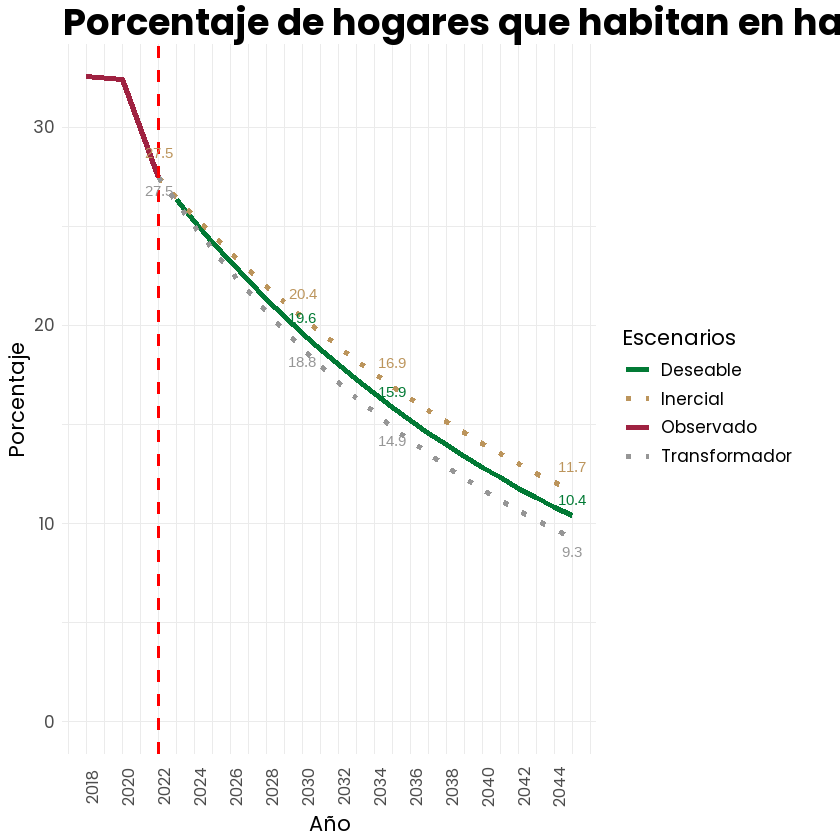

In [21]:
grafica_bonita(
  data = serie_completa,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de hogares que habitan en hacinamiento",
  linea_vertical = 2022,
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

ggsave("hacinamiento_estimada.png", width = 12, height = 10, dpi = 100, bg = "white")